# Approximating Implicit Matrix Factorization with Shallow Neural Networks

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


# resources
- https://arxiv.org/pdf/1606.07674.pdf

In [5]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [77]:
from collections import namedtuple
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF
from dotify.resources.countries import countries as countries_lookup

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline
plt.style.use('seaborn')

# Abstract

## Implicit Matrix Factorization

The Implicit Matrix Factorization (IMF) algorithm as presented by [Hu, Koren and Volinksy](http://yifanhu.net/PUB/cf.pdf) is a widely popular, effective method for recommending items to users. This approach was born from necessity: while explicit feedback as to our users' tastes - a questionnaire completed at user signup, for example - makes building a recommendation engine straightforward, we often have nothing more than *implicit feedback* data - view count, click count, time spent on page, for example - which serve as nothing more than a proxy for these preferences. Crucially, the latter feedback is asymmetric: while a high view count might indicate positive preference for a given item, a low view count cannot be said to do the opposite. Perhaps, the user simply doesn't know the item is there.

IMF begins with a ratings matrix $R$, where $R_{u, i}$ gives the implicit feedback value observed for user $u$ and item $i$. Next, it constructs two other matrices defined as follows:

$$
p_{u, i} =
\begin{cases}
1 & r_{u, i} \gt 0\\
0 & r_{u, i} = 0
\end{cases}
$$
<br>
$$
c_{u, i} = 1 + \alpha r_{u, i}
$$

$P$ gives a binary matrix indicating our belief in the existence of each user's preference for each item. $C$ gives our *confidence* in the existence of each user's preference for each items where, trivially, larger values of $r_{u, i}$ give us higher confidence that user $u$ indeed likes item $i$.

Next, IMF outlines its goal: let's embed each user and item into $\mathbb{R}^f$ such that their dot product approximates the former's true preference for the latter. Finally, and naming user vectors $x_u \in \mathbb{R}^f$ and item vectors $y_i \in \mathbb{R}^f$, we compute the argmin of the following objective:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - x_u^Ty_i\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

Once sufficiently minimized, we can compute expected preferences $\hat{p}_{u, i} = x_u^Ty_i$ for unobserved $\text{(user, item)}$ pairs; recommendation then becomes:
1. For a given user $u$, compute predicted preferences $\hat{p}_{u, i} = x_u^Ty_i$ for all items $i$.
2. Sort the list in descending order.
3. Returning the top $n$ items.

## Shallow neural networks
IMF effectively gives a function $f: u, i \rightarrow \hat{p}_{u, i}$. As before, our goal is to minimize the function above, which we can now rewrite as:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - f(u, i)\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

To approximate this function, I turn to our favorite [universal function approximator](http://neuralnetworksanddeeplearning.com/chap4.html): neural networks optimized with gradient descent.

This work is built around a toy web application I authored long ago: [dotify](http://dotify.herokuapp.com/). At present, dotify:
- Pulls data nightly from [Spotify Charts](https://spotifycharts.com/regional). These data contain the number of streams for that day's top 200 songs for each of 55 countries.
- Computes an implicit matrix factorization nightly, giving vectors for both countries and songs.
- Allows the user to input a "country-arithmetic" expression, i.e. "I want music like `Colombia x Turkey - Germany`." It then performs this arithmetic with the chosen vectors and recommends songs to the composite.

In this work, I first fit and cross-validate an implicit matrix factorization model, establishing the three requisite parameters: $f$, the dimensionality of the latent vectors; $\alpha$, the scalar multiple used in computing $C$; $\lambda$ the regularization strength used in on our loss function.

### Network architectures

Next, I explore five different shallow neural network architectures in attempt to improve upon the observed results. These architectures are as follows:

1. A trivially "Siamese" network which first embeds each country and song index into $\mathbb{R}^f$ in parallel then computes a dot-product of the embeddings. This is roughly equivalent to what is being done by IMF.
2. Same as previous, but with a bias embedding for each set, in $\mathbb{R}$, added to the dot-product.
3. Same as #1, but concatenate the vectors instead. Then, stack 3 fully-connected layers with ReLU activations, batch normalization after each, and dropout after the first. Finally, add a 1-unit dense layer on the end, and add bias embeddings to the result. (NB: I wanted to add the bias embeddings to the respective $\mathbb{R}^f$ embeddings at the outset, but couldn't figure out how to do this in Keras.)
4. Same as #2, except feed in the song title text as well. This text is first tokenized, then padded to a maximum sequence length, then embedded into a fixed-length vector by an LSTM, then reduced to a single value by a dense layer with ReLU activation. Finally, this scalar is concatenated to the scalar output that #2 would produce, and the result is fed into a final dense layer with a linear activation - i.e. a linear combination of the two.
5. Same as #4, except feed in the song artist index as well. This index is first embedded into a vector, then reduced to a scalar by a dense layer with ReLu activation. Finally, this scalar is concatenated with the two scalars produced in the second-to-last layer of #4, then fed into a final dense layer with a linear activation. Like the previous, this is a linear combination of the three inputs.

# add the links in here

# Results

# Data preparation

To construct our ratings matrix, I take the sum of total streams for each $\text{(country, song)}$ pair. The data are limited to a given number of "top songs," defined as a song that appeared on Spotify Charts *on a given date*.

Because the values exist on wildly different orders of magnitude, I scale the results as follows:

$$\tilde{r}_{u, i} = \log{\bigg(\frac{1 + r_{u, i}}{\epsilon}\bigg)}$$

To start, let's build a ratings matrix for a small sample of the data.

In [47]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)
ratings_matrix.R_ui.head()

song_id,5552,5553,5557,5558,5560,5562,5565,5582,5583,5585,...,33062,33064,33065,33066,33067,33068,33069,33070,33071,33072
country_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,3.643437,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.546472,0.0,0.0,3.597833,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,3.175760,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,1.138153,0.961264,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's get an idea of the sparsity of our data and how many songs each country has streamed.

In [48]:
sparsity = (ratings_matrix.R_ui == 0).mean().mean()
non_zero_entries_percent = 100*np.round(1 - sparsity, 4)

print('Our ratings matrix has {}% non-zero entries.'.format(non_zero_entries_percent))

Our ratings matrix has 7.3999999999999995% non-zero entries.


In [49]:
print('Our ratings matrix contains {} countries and {} unique songs.'.format(*ratings_matrix.R_ui.shape))

Our ratings matrix contains 55 countries and 2110 unique songs.


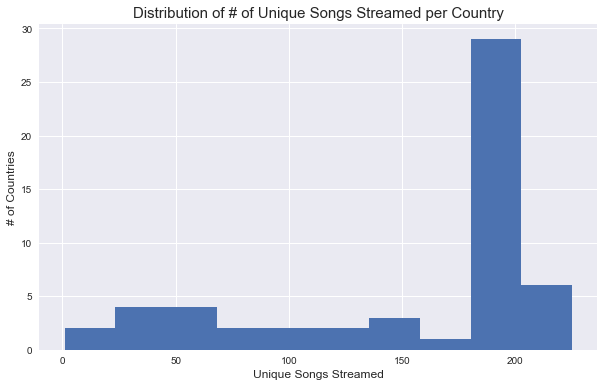

In [40]:
plt.figure(figsize=(10, 6))

songs_rated_by_country = (ratings_matrix.R_ui > 0).sum(axis=1)
plt.hist(songs_rated_by_country)
plt.title('Distribution of # of Unique Songs Streamed per Country', fontsize=15)
plt.xlabel('Unique Songs Streamed', fontsize=12)
_ = plt.ylabel('# of Countries', fontsize=12)

## Construct training, validation sets

In reviewing literature on recommender engine evaluation, it seems common to create training and validation sets as follows:
1. Filter your ratings matrix for users (countries) that meet some criterion, i.e. they've streamed above a certain threshold of songs.
2. Select a random $x\%$ of their items (songs).
3. "Move" these items into a validation matrix; set them to 0 in the training matrix.

To construct this split, I first compute a sensible threshold for Step #1, then "move" a random 20% of songs from the training matrix to the validation matrix.

In [41]:
print('The 15th percentile of songs rated by country is {}.'.format(
    np.percentile(songs_rated_by_country, 15)
))

The 15th percentile of songs rated by country is 54.5.


Let's choose 50 as our cutoff, and move 20% of the songs in qualifying rows to a validation set.

NB: The actual ratings matrix is located at `RatingsMatrix.R_ui`. This reflects the API choice I made when first starting this project.

In [42]:
more_than_50_ratings_mask = songs_rated_by_country > 50

In [43]:
FRACTION_TO_DROP = .2
TRAINING_MATRIX = ratings_matrix
VALIDATION_MATRIX = deepcopy(TRAINING_MATRIX)
VALIDATION_MATRIX.R_ui = pd.DataFrame(0., index=TRAINING_MATRIX.R_ui.index, columns=TRAINING_MATRIX.R_ui.columns)

for country_id, ratings in TRAINING_MATRIX.R_ui[more_than_50_ratings_mask].iterrows():
    
    rated_songs_mask = TRAINING_MATRIX.R_ui.ix[country_id] > 0
    rated_songs = TRAINING_MATRIX.R_ui.ix[country_id][rated_songs_mask].index.tolist()
    n_songs_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    songs_to_drop = set( random.sample(rated_songs, n_songs_to_drop) )
    
    VALIDATION_MATRIX.R_ui.ix[country_id][songs_to_drop] = TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop]
    TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop] = 0.

# Evaluation

Evaluating recommender systems is an inexact science because there is no "right" answer. In production, this evaluation is often done via the A/B test of a proxy metric important to the business - revenue, for example. In training, the process is less clear. To this end, the authors of the IMF paper offer the following:

> Evaluation of implicit-feedback recommender requires appropriate measures. In the traditional setting where a user is specifying a numeric score, there are clear metrics such as mean squared error to measure success in prediction. However with implicit models we have to take into account availability of the item, competition for the item with other items, and repeat feedback. For example, if we gather data on television viewing, it is unclear how to evaluate a show that has been watched more than once, or how to compare two shows that are on at the same time, and hence cannot both be watched by the user.

Additionally, they state:

> It is important to realize that we do not have a reliable feedback regarding which programs are unloved, as not watching a program can stem from multiple different reasons. In addition, we are currently unable to track user reactions to our recommendations. Thus, precision based metrics are not very appropriate, as they require knowing which programs are undesired to a user. However, watching a program is an indication of liking it, making recall-oriented measures applicable.

In solution, they propose evaluating the "expected percentile ranking" defined as follows:

$$
\overline{\text{rank}} = \frac{\sum_{u, i}\tilde{r}_{u, i}^t\text{rank}_{u, i}}{\sum_{u, i}\tilde{r}_{u, i}^t}
$$

Here, $\text{rank}_{u, i}$ gives the percentile-ranking of the predicted preference, i.e. if $\hat{p}_{u = 17, i = 34}$ is the largest of all predicted preferences, then $\text{rank}_{u = 17, i = 34} = 0\%$. Similarly, the smallest of the predicted preferences, i.e. the last on the list, equals $100\%$.

The following class accepts a training matrix, validation matrix and a matrix of predicted preferences. It then exposes the mean expected percentile ranking for both training and validation sets as properties on the instance.

In [44]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.predicted_preferences = predicted_preferences
        self._expected_percentile_rankings_train = []
        self._expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self._expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self._expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in self.predicted_preferences[more_than_50_ratings_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings

    @property
    def mean_expected_percentile_rankings_train(self):
        return np.mean(self._expected_percentile_rankings_train)
    
    @property
    def mean_expected_percentile_rankings_validation(self):
        return np.mean(self._expected_percentile_rankings_validation)

## Grid search

Next, we perform a basic grid search to find reasonable values for $\alpha$ and $\lambda$.

In [16]:
F = 30
grid_search_results = {}
result = namedtuple('Result', 'alpha lmbda')
alpha_values = [1e-1, 1e0, 1e1, 1e2]
lmbda_values = [1e-1, 1e0, 1e1, 1e2]

for alpha in alpha_values:
    for lmbda in lmbda_values:
        implicit_mf = ImplicitMF(ratings_matrix=TRAINING_MATRIX, f=F, alpha=alpha, lmbda=lmbda)
        implicit_mf.run()
        predicted_preferences = implicit_mf.country_vectors.vectors.dot( implicit_mf.song_vectors.vectors.T )
        
        evaluator = ExpectedPercentileRankingsEvaluator(
            training_matrix=TRAINING_MATRIX,
            validation_matrix=VALIDATION_MATRIX,
            predicted_preferences=predicted_preferences
        )
        evaluator.run()
        grid_search_results[result(alpha=alpha, lmbda=lmbda)] = {
            'train': evaluator.mean_expected_percentile_rankings_train,
            'validation': evaluator.mean_expected_percentile_rankings_validation
        }

Let's visualize the results for clarity. I plot the opposite of the validation score such that the parameters corresponding to the *darkest* square are found to be most favorable.

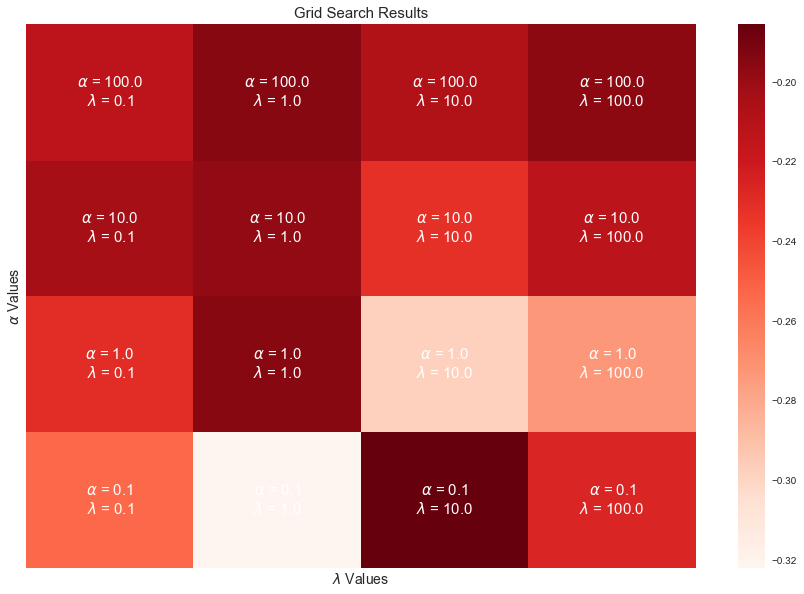

In [26]:
grid_search_items = [(params, results) for params, results in grid_search_results.items()]
grid_search_items.sort(key=lambda tup: tup[0].alpha)

params, results = zip(*grid_search_items)
validation_results = np.array([result['validation'] for result in results]).reshape(4, 4)

plt.figure(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
plt.pcolormesh(-validation_results, cmap='Reds')
plt.colorbar()
for alpha_index, alpha in enumerate(alpha_values):
    for lbmda_index, lmbda in enumerate(lmbda_values):
        plt.text(
            x = lbmda_index + 0.5,
            y = alpha_index + 0.5,
            s = r'$\alpha$ = {}'.format(alpha) + '\n' + r'$\lambda$ = {}'.format(lmbda), 
            ha='center', 
            va='center', 
            size=15, 
            color='w'
        )
plt.title('Grid Search Results', fontsize=15)
plt.xlabel(r'$\lambda$ Values', fontsize=14)
_ = plt.ylabel(r'$\alpha$ Values', fontsize=14)

In [45]:
best_params = min(grid_search_results, key=lambda key: grid_search_results.get(key)['validation'])
print('The best parameters were found to be: {}.'.format(best_params))

The best parameters were found to be: Result(alpha=0.1, lmbda=10.0).


# Train a final model

Using the best parameters, let's train a final implicit matrix factorization model using 1,000,000 top songs. Additionally, we'll choose $\epsilon = 1,000$ which seemed to work best in simple experimentation. This work is not shown here.

In [50]:
ratings_matrix = RatingsMatrix(n_top_songs=1000000, eps=1e3)

In [51]:
print('Our ratings matrix contains {} countries and {} unique songs.'.format(*ratings_matrix.R_ui.shape))

Our ratings matrix contains 55 countries and 8663 unique songs.


In [ ]:
implicit_mf = ImplicitMF(ratings_matrix=ratings_matrix, f=F, alpha=best_params.alpha, lmbda=best_params.lmbda)
implicit_mf.run()

# save stuff we care about from the final implicit mf run

In [60]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

# Visualize

Let's plot the cosine similarities between all pairs of countries to confirm that things make sense. Intuitively, I'd think that countries in the following groups should be similar:
- United States, United Kingdom, Canada, Australia, New Zealand
- Latin American countries
- Sweden, Finland, Norway, Denmark

First let's replace the index of our vectors such that it contains the country names.

In [62]:
country_vectors_df = implicit_mf.country_vectors.vectors.copy()

country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}
country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

country_vectors_df.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29
country_name,,,,,,,,,,,,,,,,,,,,,
United States,-1.276051,-1.058583,-0.622779,0.430231,0.306830,0.966786,0.190530,-0.549356,0.538788,-0.722162,...,0.057478,0.500288,0.799253,0.383243,0.575051,0.247066,0.548018,-0.238643,0.114481,0.731294
United Kingdom,0.106521,0.346207,-0.276669,-0.003249,-1.294024,-0.090318,0.666301,-0.533962,0.281620,-0.268332,...,-0.803658,-0.498773,-0.041302,-0.705815,0.624482,-0.007293,1.335080,-0.717667,0.019507,-1.700016
Argentina,-0.871966,0.678408,0.343354,-0.968614,-1.099471,0.014175,0.031833,-0.370821,-0.114270,-0.982766,...,0.435942,-0.170878,-0.172491,-0.158596,0.445267,-0.949628,0.542433,-0.157643,0.765119,0.587947
Australia,-1.129085,0.212391,0.136416,-0.665215,0.452084,-0.418566,-0.187979,0.807976,-0.693282,-0.723989,...,-0.961785,-0.064047,-0.161033,0.211444,0.180285,0.597487,-0.143220,0.336241,-0.251201,-1.057264
Austria,-0.094485,0.870111,-0.328650,-0.594735,-0.429165,-0.955718,0.151173,0.250305,-0.302996,0.718965,...,-0.409435,-0.381884,-0.144373,0.340587,0.006711,0.870717,0.067101,-0.361675,0.742727,1.341254


Then, we'll plot the cosine similarities.

In [75]:
sns.set(style="white")

def plot_cosine_similarities(country_vectors_df):

    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    lower_triangle_mask = np.zeros_like(similarities_df, dtype=np.bool)
    lower_triangle_mask[np.triu_indices_from(lower_triangle_mask)] = True

    f, ax = plt.subplots(figsize=(21, 21))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(
        similarities_df, 
        mask=lower_triangle_mask, 
        cmap=cmap, 
        vmax=.5,
        square=True, 
        xticklabels=True, 
        yticklabels=True,
        linewidths=1, 
        cbar_kws={"shrink": .5}, 
        ax=ax,
    )
    ax.set_title('Cosine Similarity Matrix', fontsize=20)

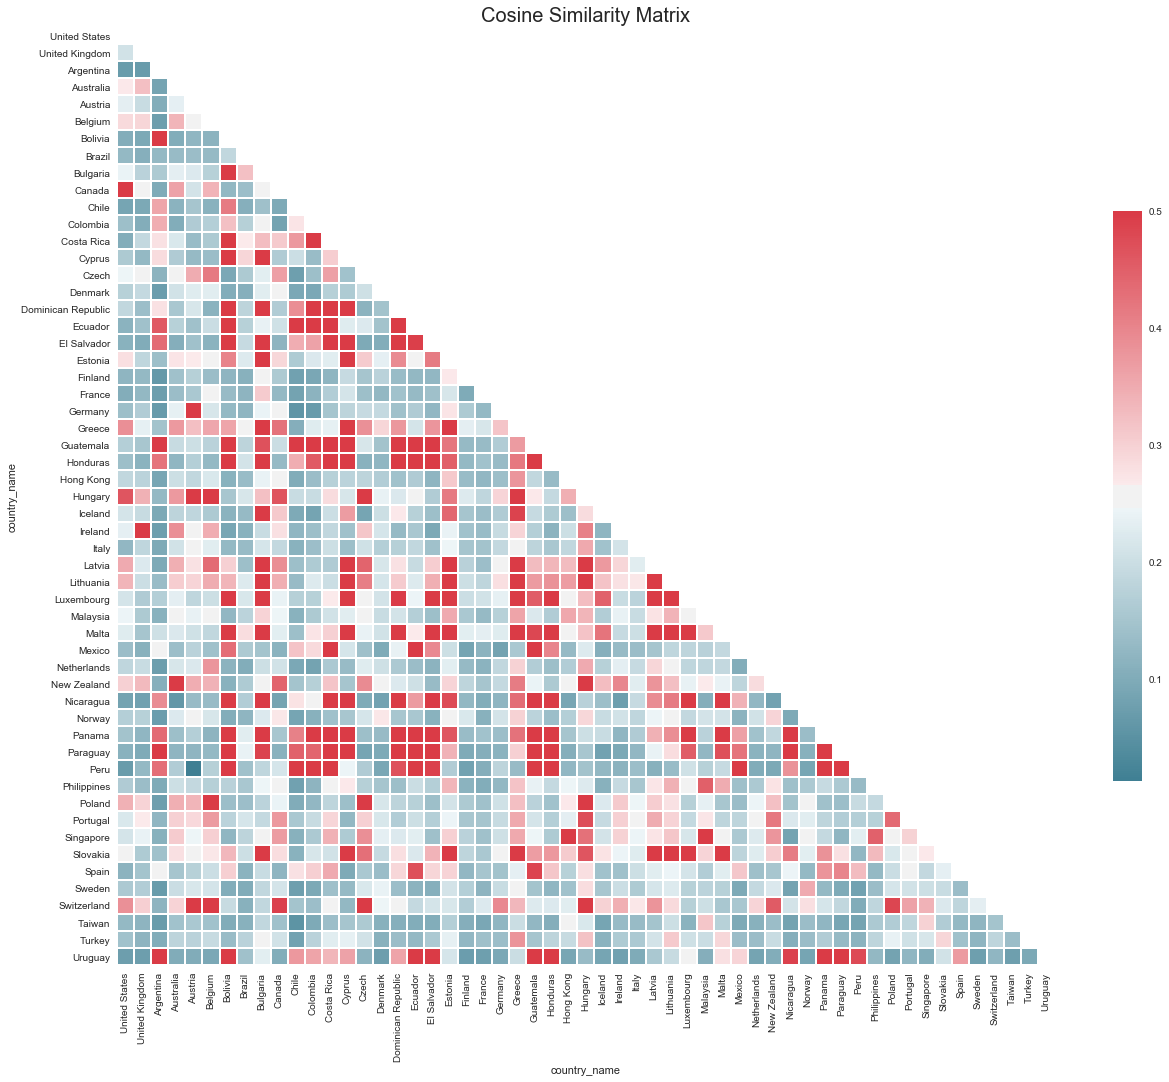

In [76]:
plot_cosine_similarities(country_vectors_df)

I first turn to my favorite country - Colombia - to inspect its similarity with other Latin American countries. The numbers are high for: Peru, Paraguay, Panama, Gautemala, Ecuador, Dominican Republic and Costa Rica.

Next, I turn to the United Kingdom: it is most similar with Switzerland, New Zealand, Ireland, Hungary, Belgium and Australia.

Finally, we see that Sweden is similar enough to Norway, yet not Finland (who, incidentally, seems to have nothing in common with anyone at all).

Overall, this looks very good to me.

# Visualize with TSNE

To further inspect similarities between countries, let's explore the 2-dimensional TSNE space.

In [84]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [88]:
def plot_tsne_embeddings(country_embeddings):

    plt.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        plt.scatter(dim_1, dim_2)
        plt.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        plt.title('Two-Dimensional TSNE Embeddings of Latent Country Vectors', fontsize=16)
        plt.xlabel('Dimension 1', fontsize=12)
        plt.ylabel('Dimension 2', fontsize=12)
    plt.show()

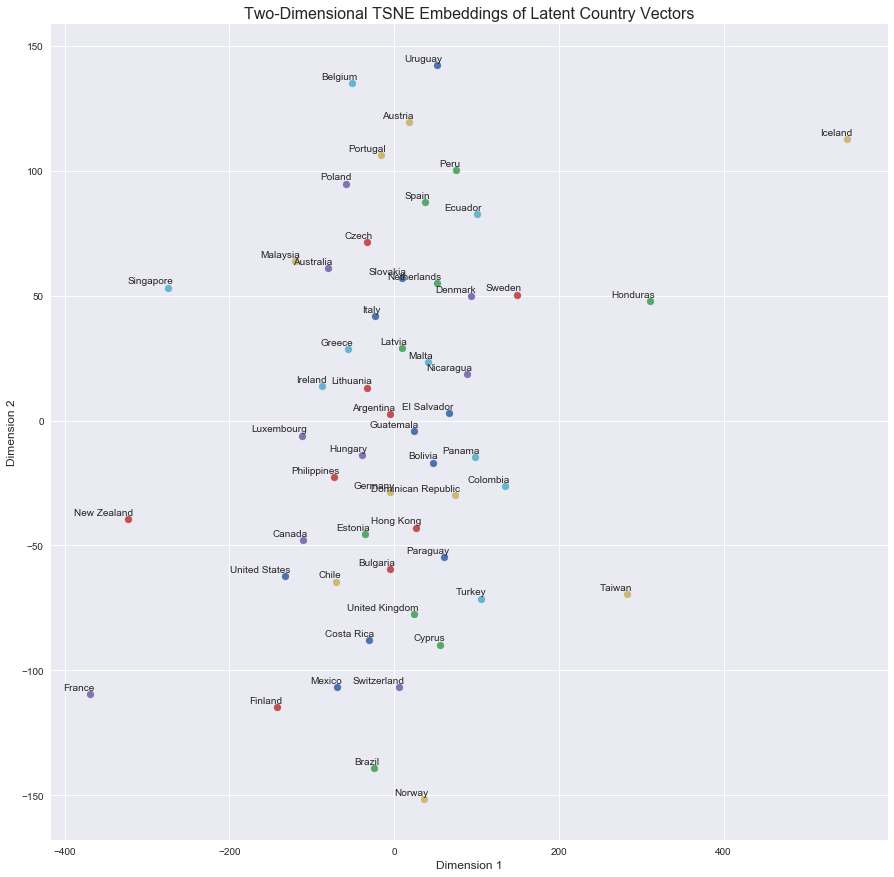

In [89]:
plot_tsne_embeddings(country_embeddings)

My first thought is that this is not immensely helpful. While we do see some of the same structure as before - Colombia close to the Dominican Republic, Panama, Bolivia, Guatemala, El Salvador; the United States close enough to the United Kingdom and Canada; Sweden nowhere near Norway, but next to Denmark - the similarities are not quite as expressive as in the cosine similarity matrix. This is OK, though; this step is worthwhile nonetheless.

## Inspect arithmetic combinations

In [ ]:
SONG_METADATA_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        songs.id as song_id
    FROM songs
"""

song_metadata_df = pd.read_sql(SONG_METADATA_QUERY, ENGINE, index_col=['song_id'])

In [ ]:
song_vectors_df = song_metadata_df.join(implicit_mf.song_vectors.vectors, how='inner')\
    .set_index(['song_title', 'song_artist'])

In [ ]:
song_vectors_df = song_vectors_df.apply(lambda vec: vec / np.linalg.norm(vec), axis = 1)
# normalize all country vectors here

In [ ]:
country_vec = country_vectors_df.ix['United States'] / np.linalg.norm(country_vectors_df.ix['United States'])

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

In [ ]:
country_vec = country_vectors_df.ix['Colombia'] / np.linalg.norm(country_vectors_df.ix['Colombia'])
# country_vec = country_vectors_df.ix['Colombia']

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

In [ ]:
country_vec = country_vectors_df.ix['Germany'] / np.linalg.norm(country_vectors_df.ix['Germany'])
# country_vec = country_vectors_df.ix['Panama']

In [ ]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

# hit it with the neural network

In [ ]:
from itertools import product

from keras import backend as K
from keras.layers import Input, Embedding, Flatten, Lambda, Dense, BatchNormalization, Dropout, LSTM
from keras.layers.merge import add, dot, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2

In [ ]:
alpha = 1
lmbda = 25
F = 30
LEARNING_RATE = .001

In [ ]:
P_ui = TRAINING_MATRIX.R_ui > 0
C_ui = 1 + alpha*TRAINING_MATRIX.R_ui

In [ ]:
def implicit_cf_loss(y_true, y_pred, alpha=alpha):
    P = y_true > 0
    C = 1 + alpha*y_true
    return K.mean( C*(P - y_pred)**2 )

## neatly arrange all the data

In [ ]:
song_metadata_df = song_metadata_df.ix[ratings_matrix.R_ui.columns]

In [ ]:
song_metadata_df.head()

In [ ]:
country_id_to_index = {c_id: index for index, c_id in enumerate(ratings_matrix.R_ui.index)}
song_id_to_index = {s_id: index for index, s_id in enumerate(ratings_matrix.R_ui.columns)}
song_artist_to_index = {artist: index for index, artist in enumerate(song_metadata_df['song_artist'].unique())}

In [ ]:
song_metadata_df['song_index'] = song_metadata_df.index.map(song_id_to_index.get)
song_metadata_df['song_artist_index'] = song_metadata_df['song_artist'].map(song_artist_to_index.get).astype(int)

In [ ]:
song_metadata_df.head()

In [ ]:
NUM_WORDS = 5000

In [ ]:
tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True, split=" ")
tokenizer.fit_on_texts(song_metadata_df['song_title'])
song_metadata_df['title_sequence'] = tokenizer.texts_to_sequences(song_metadata_df['song_title'])

In [ ]:
input_tuples = list( product(ratings_matrix.R_ui.index, ratings_matrix.R_ui.columns) )
country_ids, song_ids = zip(*input_tuples)

ratings_df = pd.DataFrame({
    'country_id': country_ids,
    'song_id': song_ids,
    'train_rating': TRAINING_MATRIX.R_ui.values.flatten(),
    'validation_rating': VALIDATION_MATRIX.R_ui.values.flatten(),
})

In [ ]:
ratings_df = ratings_df.join(song_metadata_df, on='song_id', how='inner').sort_index()
ratings_df['country_index'] = ratings_df['country_id'].map(country_id_to_index.get)

In [ ]:
n_countries = ratings_df['country_index'].nunique()
n_songs = ratings_df['song_index'].nunique()

# a function to rearrange our predictions

In [ ]:
def generate_predictions(model, inputs, ratings_df=ratings_df):
    predictions = model.predict(x=inputs)
    return pd.DataFrame({
        'prediction': predictions.flatten(),
        'country_id': ratings_df['country_id'],
        'song_id': ratings_df['song_id']
    }).pivot('country_id', 'song_id', 'prediction')

In [ ]:
def evaluate_predictions(predictions, training_matrix=TRAINING_MATRIX, validation_matrix=VALIDATION_MATRIX):
    evaluator = ExpectedPercentileRankingsEvaluator(
        training_matrix=training_matrix,
        validation_matrix=validation_matrix,
        predicted_preferences=predictions
    )
    evaluator.run()
    print('Train: {}'.format(np.mean(evaluator.expected_percentile_rankings_train)))
    print('Validation: {}'.format(np.mean(evaluator.expected_percentile_rankings_validation)))

# first model

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)

song_input = Input(shape=(1,), dtype='int64', name='song')
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# add bias terms

In [ ]:
country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# the full model with biases and more layers

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

concatenation = concatenate([country_embedding, song_embedding])

dense_layer = Dense(activation='relu', units=10)(concatenation)
dropout = Dropout(.5)(dense_layer)
batch_norm = BatchNormalization()(dropout)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)

predicted_preference = Dense(units=1, name='predicted_preference')(batch_norm)
predicted_preference = Flatten()(predicted_preference)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# flip it around

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

dense_layer_1_country = Dense(activation='relu', units=F)(country_embedding)
dense_layer_1_song = Dense(activation='relu', units=F)(song_embedding)
dense_layer_2_country = Dense(activation='relu', units=F)(dense_layer_1_country)
dense_layer_2_song = Dense(activation='relu', units=F)(dense_layer_1_song)
dense_layer_2_country = BatchNormalization()(dense_layer_2_country)
dense_layer_2_song = BatchNormalization()(dense_layer_2_song)
dense_layer_3_country = Dense(activation='linear', units=F, activity_regularizer=l2(lmbda))(dense_layer_2_country)
dense_layer_3_song = Dense(activation='linear', units=F, activity_regularizer=l2(lmbda))(dense_layer_2_song)

predicted_preference = dot(inputs=[dense_layer_3_country, dense_layer_3_song], axes=2)
predicted_preference = Flatten()(predicted_preference)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

In [ ]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# feed in the text as well

In [ ]:
MAX_SEQUENCE_LENGTH = ratings_df['title_sequence'].map(len).max()

padded_title_sequences = pad_sequences(sequences=ratings_df['title_sequence'], maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
title_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='song_title_sequence')
title_embedding = Embedding(output_dim=F, input_dim=NUM_WORDS, input_length=MAX_SEQUENCE_LENGTH)(title_input)
title_lstm = LSTM(F)(title_embedding)
dense_title_lstm = Dense(units=1, activation='relu')(title_lstm)

In [ ]:
country_input = Input(shape=(1,), dtype='int64', name='country')
country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)

song_input = Input(shape=(1,), dtype='int64', name='song')
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

country_bias = Flatten()(country_bias)
song_bias = Flatten()(song_bias)

predicted_preference = add(inputs=[predicted_preference, country_bias])
predicted_preference = add(inputs=[predicted_preference, song_bias])

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [ ]:
model = Model(inputs=[country_input, song_input, title_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [ratings_df['country_index'], ratings_df['song_index'], padded_title_sequences]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

# finally, add the artist in there

In [ ]:
n_artists = ratings_df['song_artist_index'].nunique()

In [ ]:
artist_input = Input(shape=(1,), dtype='int64', name='artist')
artist_embedding = Embedding(input_dim=n_artists, output_dim=F, embeddings_regularizer=l2(lmbda))(artist_input)
dense_artist_embedding = Dense(units=1, activation='relu')(artist_embedding)
dense_artist_embedding = Flatten()(dense_artist_embedding)

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm, dense_artist_embedding])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [ ]:
model = Model(inputs=[country_input, song_input, title_input, artist_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [
    ratings_df['country_index'], 
    ratings_df['song_index'], 
    padded_title_sequences, 
    ratings_df['song_artist_index']
]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)